Scenario
A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

Goal
Evaluate A/B testing results and decide which marketing strategy works the best.

Columns
MarketID: unique identifier for market
MarketSize: size of market area by sales
LocationID: unique identifier for store location
AgeOfStore: age of store in years
Promotion: one of three promotions that were tested
week: one of four weeks when the promotions were run
SalesInThousands: sales amount for a specific LocationID, Promotion, and week

In [31]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

In [32]:
def import_file(file, sep=","):
    print("------------Data importation has started.------------\n")
    if ".csv" in file:
        data = pd.read_csv(file, sep=sep)
    elif ".xlsx" in file:
        data = pd.read_excel(file, sep=sep)
    if len(data) > 0:
        print("------------Data has been successfully imported!------------\n")
        print(f"------------Data has {data.shape[0]} rows and {data.shape[1]} columns------------\n")
        print("------------General information about data------------\n")
        print(f"{data.info()}\n")
        print("------------Statistical summary of data------------\n")
        print(f"{data.describe()}\n")
        print("------------Is there any missing values???------------\n")
        print(f"{data.isna().sum()}\n")
        print("------------Is there any duplicated rows???------------\n")
        print(f"{data.duplicated().sum()}\n")
        print("------------Taking a look at the first few rows of data...------------\n")
        print(f"{data.head()}\n")
    else:
        print("------------Data importation has failed!!!------------")
    return data

In [33]:
df = import_file("WA_Marketing-Campaign.csv", sep=",")

------------Data importation has started.------------

------------Data has been successfully imported!------------

------------Data has 548 rows and 7 columns------------

------------General information about data------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB
None

------------Statistical summary of data------------

         MarketID  LocationID  AgeOfStore   Promotion        week  \
count  548.000000  548.000000  548.000000  548.00000

In [34]:
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

In [35]:
df_edited = df.copy()

In [36]:
categorical_columns = []

for column in df_edited.columns:
    if df_edited[column].dtype in ["object", "category", "bool"]:
        categorical_columns.append(column)
    elif df_edited[column].dtype in ["float64", "int64"]:
        if df_edited[column].nunique() <= 11:
            categorical_columns.append(column)
        else:
            continue


print(categorical_columns)


for column in categorical_columns:
    df_edited[column] = df_edited[column].astype("category")

print(df_edited.dtypes)

['MarketID', 'MarketSize', 'Promotion', 'week']
MarketID            category
MarketSize          category
LocationID             int64
AgeOfStore             int64
Promotion           category
week                category
SalesInThousands     float64
dtype: object


In [37]:
bins = [1,5,10,15,20,25]
labels = ["1-5", "5-10", "10-15", "15-20", "20+"]
df_edited["AgeCategory"] = pd.cut(df_edited["AgeOfStore"], bins=bins, labels=labels, right=True)

df_edited.drop(columns="AgeOfStore", inplace=True)

print(df_edited.head())
print(df_edited.dtypes)

  MarketID MarketSize  LocationID Promotion week  SalesInThousands AgeCategory
0        1     Medium           1         3    1             33.73         1-5
1        1     Medium           1         3    2             35.67         1-5
2        1     Medium           1         3    3             29.03         1-5
3        1     Medium           1         3    4             39.25         1-5
4        1     Medium           2         2    1             27.81         1-5
MarketID            category
MarketSize          category
LocationID             int64
Promotion           category
week                category
SalesInThousands     float64
AgeCategory         category
dtype: object


In [38]:
for column in df_edited.columns:
    if df_edited[column].nunique() <= 10:
        print(df_edited[column].value_counts())

MarketID
3     88
10    80
5     60
6     60
7     60
1     52
8     48
9     40
4     36
2     24
Name: count, dtype: int64
MarketSize
Medium    320
Large     168
Small      60
Name: count, dtype: int64
Promotion
2    188
3    188
1    172
Name: count, dtype: int64
week
1    137
2    137
3    137
4    137
Name: count, dtype: int64
AgeCategory
5-10     168
1-5      140
10-15     80
15-20     36
20+       36
Name: count, dtype: int64


In [39]:
def add_value_labels(ax, fontsize=8, fontweight="bold"):
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=fontsize, fontweight=fontweight)

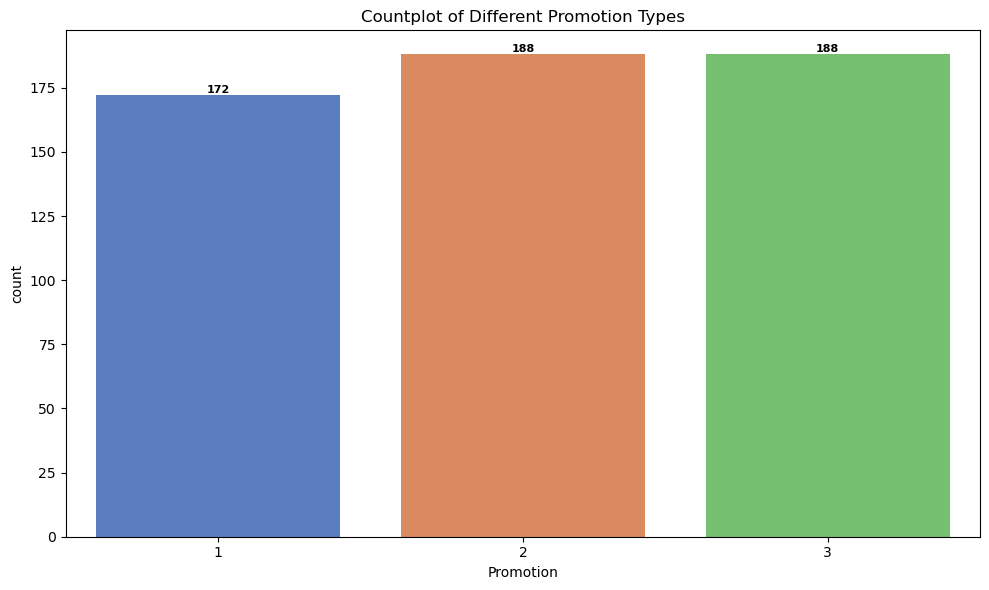

In [40]:
plt.figure(figsize = (10,6))
ax1 = sns.countplot(data=df_edited, x="Promotion", palette="muted")
plt.title("Countplot of Different Promotion Types")

add_value_labels(ax1)


plt.tight_layout()
plt.show()

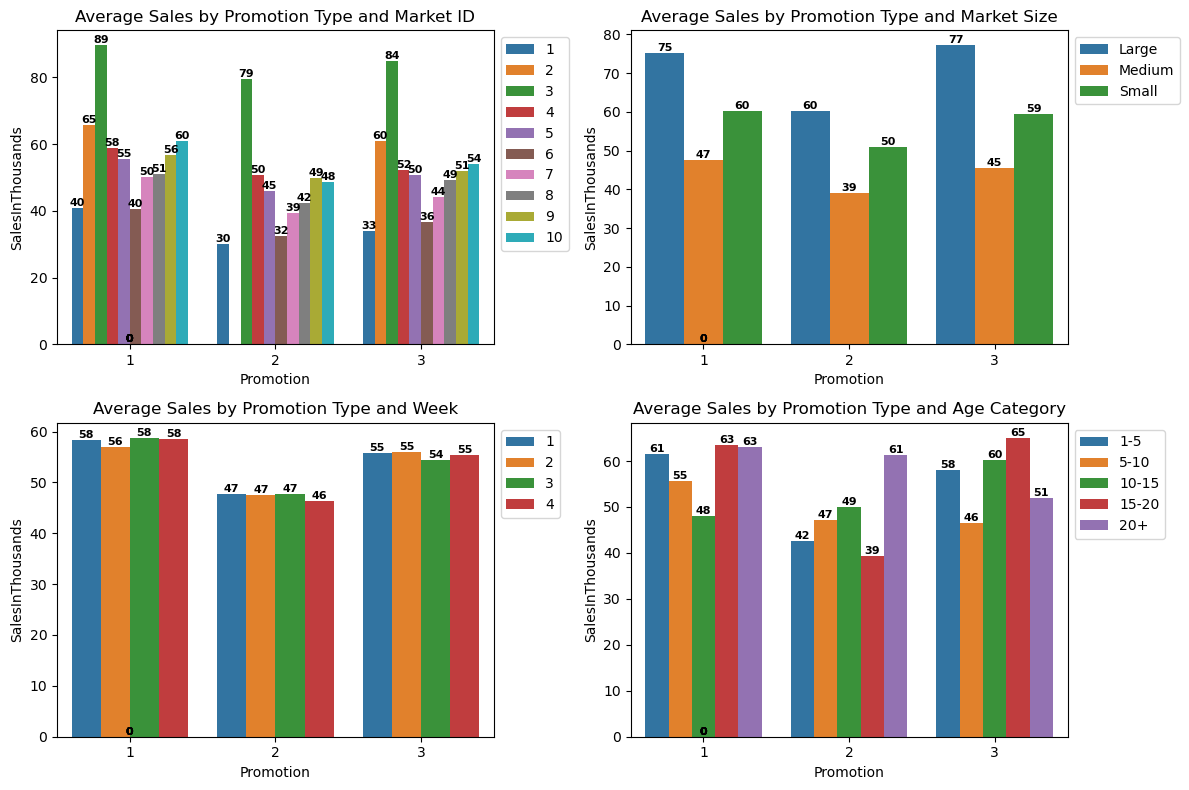

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))


ax1 = sns.barplot(data=df_edited, x="Promotion", y="SalesInThousands", hue="MarketID",  ci=None, ax=axes[0,0])
axes[0,0].set_title("Average Sales by Promotion Type and Market ID")


ax2 = sns.barplot(data=df_edited, x="Promotion", y="SalesInThousands", hue="MarketSize", ci=None, ax=axes[0,1])
axes[0,1].set_title("Average Sales by Promotion Type and Market Size")


ax3 = sns.barplot(data=df_edited, x="Promotion", y="SalesInThousands", hue="week", ci=None, ax=axes[1,0])
axes[1,0].set_title("Average Sales by Promotion Type and Week")


ax4 = sns.barplot(data=df_edited, x="Promotion", y="SalesInThousands", hue="AgeCategory", ci=None, ax=axes[1,1])
axes[1,1].set_title("Average Sales by Promotion Type and Age Category")


add_value_labels(ax1)
add_value_labels(ax2)
add_value_labels(ax3)
add_value_labels(ax4)

for ax in fig.axes:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

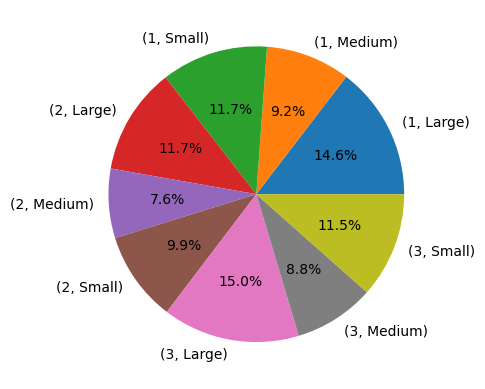

In [42]:
df_edited.groupby(["Promotion", "MarketSize"])["SalesInThousands"].mean().plot(kind="pie", autopct='%1.1f%%')
plt.ylabel("")
plt.show()

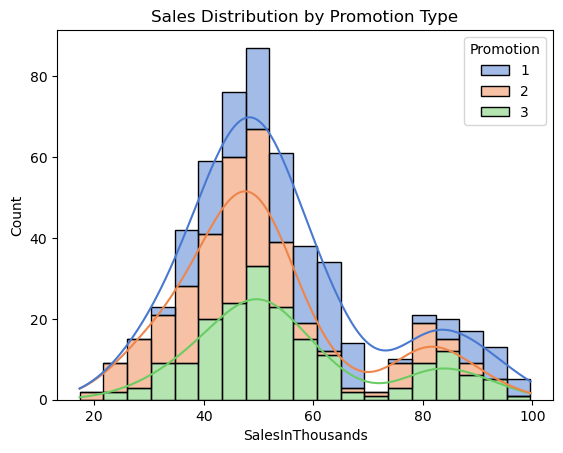

In [43]:
sns.histplot(data=df_edited, x="SalesInThousands", hue="Promotion", palette="muted", kde=True, multiple="stack")
plt.title("Sales Distribution by Promotion Type")
plt.show()

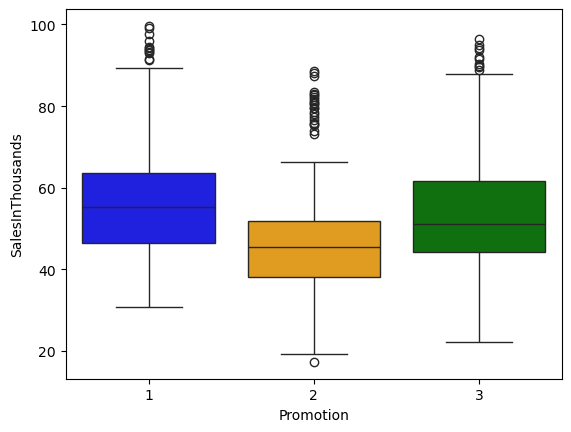

In [44]:
sns.boxplot(data=df_edited, x="Promotion", y="SalesInThousands", palette = {"1":"blue", "2":"orange", "3":"green"})
plt.show()

First we will run A/B test without removing outliers. 
Then we will run A/B test again this time making outliers equal to lower or upper bound.

### Shapiro-Wilk Test for Normality
The function `shapiro_test()` checks whether the `SalesInThousands` column follows a normal distribution for each unique value in a categorical column by applying the **Shapiro-Wilk test**.

**H0**: Data is **normally distributed**. 
**Ha**: Data is **not normally distributed**.

If the **p-value < 0.05**, the null hypothesis is rejected, indicating that the data **is not normally distributed**.

In [59]:
def shapiro_test(df, column):
    results = []
    if df[column].dtype in ["object", "category", "bool"]:
        for variable in df[column].unique():
            shapiro = stats.shapiro(df[df[column] == variable]["SalesInThousands"])
            results.append(
                {
                    "Column":column,
                    "Variable":variable,
                    "p-value":shapiro.pvalue,
                    "Conclusion": "Not Normally Distributed" if shapiro.pvalue < 0.05 else "Normally Distributed"
                })
    results_df = pd.DataFrame(results)
    return results_df

In [60]:
shapiro_test(df = df_edited, column = "Promotion")

,Column,Variable,p-value,Conclusion
0,Promotion,3,1.499466e-08,Not Normally Distributed
1,Promotion,2,5.457100e-09,Not Normally Distributed
2,Promotion,1,1.977265e-08,Not Normally Distributed


### Levene's Test for Homogeneity of Variances  
The function `levene_test()` checks whether the variance of a numerical column is equal across different groups in a categorical column by applying **Levene’s test**.

**H0**: Groups **have equal variance** (homoscedasticity).  
**Ha**: Groups **do not have equal variance** (heteroscedasticity).

If the **p-value < 0.05**, the null hypothesis is rejected, indicating that the groups **do not have equal variance**.


In [61]:
def levene_test(df, category_column, variable_column):
    results = []
    
    unique_categories = df[category_column].unique()
    groups = [df[df[category_column] == category][variable_column] for category in unique_categories]
    levene_test_result = stats.levene(*groups)
    
    results.append(
        {
            "Column":category_column,
            "p-value":levene_test_result.pvalue,
            "Comment": "Does Not Have Equal Variance" if levene_test_result.pvalue < 0.05 else "Has Equal Variance"
        })
    results_df = pd.DataFrame(results)
    
    return results_df

In [62]:
levene_test(df = df_edited, category_column = "Promotion", variable_column = "SalesInThousands")

,Column,p-value,Comment
0,Promotion,0.281751,Has Equal Variance


Since the data is not normally distributed and there are multiple categories, we will assess whether there are significant differences among promotion types using the **Kruskal-Wallis test**, a non-parametric alternative to ANOVA. This test determines whether at least one group differs statistically from the others in terms of the given variable.

### Kruskal-Wallis Test for Comparing Multiple Groups  
The function `kruskal_test()` checks whether there is a statistically significant difference in a numerical column across different groups in a categorical column by applying the **Kruskal-Wallis test**.

**H0**: Groups have the **same distribution**.  
**Ha**: At least one group **differs significantly**.

If the **p-value < 0.05**, the null hypothesis is rejected, indicating that there is a **statistically significant difference** between at least one of the groups.

In [63]:
def kruskal_wallis_test(df, category_column, variable_column):
    results = []
    
    unique_categories = df[category_column].unique()
    groups = [df[df[category_column] == category][variable_column] for category in unique_categories]
    kruskal_results = stats.kruskal(*groups)
    
    results.append(
        {
            "Column":category_column,
            "p-value":kruskal_results.pvalue,
            "Comment": "Statistically Significant Difference" if kruskal_results.pvalue < 0.05 else "No Statistically Significant Difference"
        })
    results_df = pd.DataFrame(results)
    
    return results_df

In [64]:
kruskal_wallis_test(df = df_edited, category_column = "Promotion", variable_column = "SalesInThousands")

,Column,p-value,Comment
0,Promotion,2.674187e-12,Statistically Significant Difference


Since there are multiple categories, we will conduct a **Tukey's HSD (Honestly Significant Difference) test** to determine which specific groups differ significantly from each other after identifying an overall difference using the **Kruskal-Wallis test**. Tukey’s test is a post-hoc analysis that controls for multiple comparisons.

### Tukey's HSD Test for Pairwise Comparisons  
The function `tukey_test()` performs **Tukey’s HSD test** to identify which groups within a categorical variable show statistically significant differences in a numerical column.

**H0**: There is **no significant difference** between group means.  
**Ha**: There is a **statistically significant difference** between at least one pair of groups.

If the **adjusted p-value < 0.05**, the null hypothesis is rejected for that comparison, indicating a significant difference between the respective groups.


In [ ]:
def tukey_test(df, category, variable):
    from statsmodels.stats.multicomp import MultiComparison
    comparison = MultiComparison(df[variable], df[category])
    tukey = comparison.tukeyhsd(0.05)
    return tukey.summary()

In [65]:
tukey_test(df=df_edited, category="Promotion", variable="SalesInThousands")

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-10.7696,0.0,-14.7738,-6.7654,True
1,3,-2.7345,0.2444,-6.7388,1.2697,False
2,3,8.0351,0.0,4.1208,11.9493,True


Now we will deal with the outliers and run the same tests.

In [45]:
df_no_outliers = df_edited.copy()

In [46]:
def find_outliers(df, variable, category):
    bounds = {}
    for column in df[category].unique():
        data = df[df[category] == column]
        q1 = data[variable].quantile(0.25)
        q3 = data[variable].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        bounds[column] = (lower_bound, upper_bound)
    return bounds

In [47]:
find_outliers(df= df_no_outliers, variable = "SalesInThousands", category="Promotion")

{3: (17.89500000000001, 88.035),
 2: (17.807500000000008, 72.10749999999999),
 1: (20.455000000000016, 89.51499999999999)}

In [16]:
def replace_outliers(df, variable, category):
    bounds = find_outliers(df, variable, category)
    for column, (lower_bound, upper_bound) in bounds.items():
        df.loc[(df[category] == column) & (df[variable] < lower_bound), variable] = lower_bound
        df.loc[(df[category] == column) & (df[variable] > upper_bound), variable] = upper_bound

In [48]:
replace_outliers(df= df_no_outliers, variable = "SalesInThousands", category="Promotion")

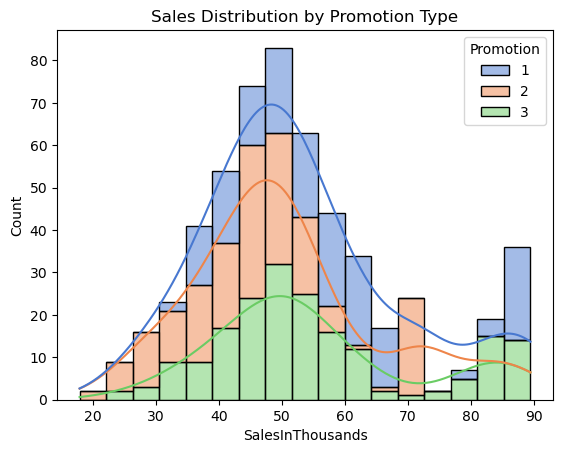

In [75]:
sns.histplot(data=df_no_outliers, x="SalesInThousands", hue="Promotion", palette="muted", kde=True, multiple="stack")
plt.title("Sales Distribution by Promotion Type")
plt.show()

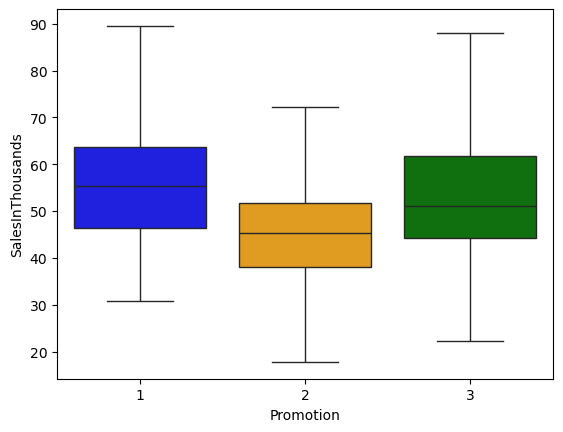

In [49]:
sns.boxplot(data=df_no_outliers, x="Promotion", y="SalesInThousands", palette = {"1":"blue", "2":"orange", "3":"green"})
plt.show()

In [52]:
shapiro_test(df = df_no_outliers, column = "Promotion")

,Column,Variable,p-value,Conclusion
0,Promotion,3,7.056882e-09,Not Normally Distributed
1,Promotion,2,1.256948e-06,Not Normally Distributed
2,Promotion,1,1.596761e-08,Not Normally Distributed


In [54]:
levene_test(df = df_no_outliers, category_column = "Promotion", variable_column = "SalesInThousands")

,Column,p-value,Comment
0,Promotion,0.040778,Does Not Have Equal Variance


In [56]:
kruskal_wallis_test(df = df_no_outliers, category_column = "Promotion", variable_column = "SalesInThousands")

,Column,p-value,Comment
0,Promotion,9.029332e-13,Statistically Significant Difference


In [58]:
tukey_test(df=df_no_outliers, category="Promotion", variable="SalesInThousands")

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-11.384,0.0,-15.1161,-7.6519,True
1,3,-2.5834,0.2352,-6.3155,1.1487,False
2,3,8.8006,0.0,5.1524,12.4488,True


In [71]:
print("Kruskal-Wallis Test Result of Data with outliers:")
print(kruskal_test(df = df_edited, category_column = "Promotion", variable_column = "SalesInThousands"))

print("\n\nKruskal-Wallis Test Result of Data without outliers:")
print(kruskal_test(df = df_no_outliers, category_column = "Promotion", variable_column = "SalesInThousands"))

Kruskal-Wallis Test Result of Data with outliers:
      Column       p-value                               Comment
0  Promotion  2.674187e-12  Statistically Significant Difference


Kruskal-Wallis Test Result of Data without outliers:
      Column       p-value                               Comment
0  Promotion  9.029332e-13  Statistically Significant Difference


In [73]:
print("Tukey's HSD Test Result of Data with outliers:")
print(tukey_test(df=df_edited, category="Promotion", variable="SalesInThousands"))

print("\n\nTukey's HSD Test Result of Data without outliers:")
print(tukey_test(df=df_no_outliers, category="Promotion", variable="SalesInThousands"))

Tukey's HSD Test Result of Data with outliers:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


Tukey's HSD Test Result of Data without outliers:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -11.384    0.0 -15.1161 -7.6519   True
     1      3  -2.5834 0.2352  -6.3155  1.1487  False
     2      3   8.8006    0.0   5.1524 12.4488   True
-----------------------------------------------------


In [74]:
df_edited.groupby("Promotion")["SalesInThousands"].mean()

Promotion
1    58.099012
2    47.329415
3    55.364468
Name: SalesInThousands, dtype: float64

### **Interpretation of the Results**  

#### **Kruskal-Wallis Test Results**  
- **p-value < 0.05**, indicating a **statistically significant difference** among at least one of the promotion types.  

#### **Tukey's HSD Test Results**  
- **Promotion 1 vs. Promotion 2** → **Promotion 1 has significantly higher sales** than Promotion 2 (**p-adj = 0.00**), as indicated by the **negative mean difference** (-10.7696 and -11.384).  
- **Promotion 1 vs. Promotion 3** → **No statistically significant difference** (**p-adj > 0.05**), meaning their sales performance is similar.  
- **Promotion 2 vs. Promotion 3** → **Promotion 3 has significantly higher sales than Promotion 2** (**p-adj = 0.00**), as shown by the **positive mean difference** (8.0351 and 8.8006).  

#### **Conclusion**  
- **Promotion 2 has the worst sales performance**, performing **significantly worse** than both **Promotion 1 and Promotion 3**.  
- **Promotion 1 and Promotion 3 perform similarly**, with **no statistically significant difference** between them.  
- **Outliers do not change the statistical significance** but slightly impact the effect size.  

### **Final Decision**  
- **Promotion 2 is the least effective and should not be preferred.**  
- **Promotion 1 and Promotion 3 perform similarly**, so either of them could be a **better choice**.